<a href="https://colab.research.google.com/github/shreyag212/Gravitational-Waves-Analysis/blob/main/Detectability_of_GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [14]:
# -- Use the following for Google Colab
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'

In [15]:
! pip install -q 'gwpy==2.0.2'

In [16]:
from IPython.display import clear_output
def progress(i,ln):
    perc = int(i/ln)
    clear_output(wait = True)
    print('Progress:', round((i/ln)*100), '%')
        
    if i == ln-1:
        clear_output(wait = True)
        #print('Done!')

## Functions


In [18]:
def format_plt(ax, xlabel, ylabel, title, cbar_ticks=[0], clr='Greys', legend=False):

  ax.set_ylabel(ylabel, fontsize=18)
  ax.set_xlabel(xlabel, fontsize = 18)
  ax.set_title(title, fontsize = 18, y=1.04, fontweight='bold')
  ax.grid(False)
  plt.setp(ax.get_xticklabels(), fontsize=16)
  plt.setp(ax.get_yticklabels(), fontsize=16)
  border = ['top', 'bottom', 'right', 'left']
  for bor in border:
    ax.spines[bor].set_linewidth(2)
    ax.spines[bor].set_color("k")
  
  if legend:
    ax.legend(fontsize=18)

  ## colorbar
  if cbar_ticks[0] != 0:
    cmap = plt.get_cmap(clr, len(q))
    norm = mpl.colors.Normalize(vmin= cbar_ticks[0], vmax=cbar_ticks[-1])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
    fig.colorbar(sm, ticks=cbar_ticks, cax=cbar_ax)
    plt.setp(cbar_ax.get_yticklabels(), fontsize=16)
    cbar_ax.set_ylabel('Mass ratio $(M_1/M_2)$ ', fontsize=18)

# Data

In [19]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.frame import query_and_read_frame
from gwpy.timeseries import TimeSeries

start = 1126258935
end = start + 64

H = query_and_read_frame('LOSC', 'H1:LOSC-STRAIN', start, end)
H = highpass(H, 10.0)                                         
H = H.crop(2, 2)
H.start_time = 0                                            

L = query_and_read_frame('LOSC', 'L1:LOSC-STRAIN', start, end)
L = highpass(L, 10.0)
L = L.crop(2, 2)
Lgwpy = TimeSeries.from_pycbc(L)
Lasd = Lgwpy.asd(fftlength=4)
Lpsd = Lgwpy.psd(fftlength=4)
L.start_time = 0                        

# Analysis

## Spectral Analysis

In GwAmplitude_Analysis.ipynb, I found that strain amplitude of GW is linearly dependent on reduced mass μ.
Now, I want to find out what happens to spectral shape of GW template if the μ is kept fixed and other parameters like mass ratio q ($M_2/M_1$) are varied.

For this, I'll fix μ = 45 $M_⊙$, $D_L$ = 500 Mpc, and vary q from 0.2 to 1.

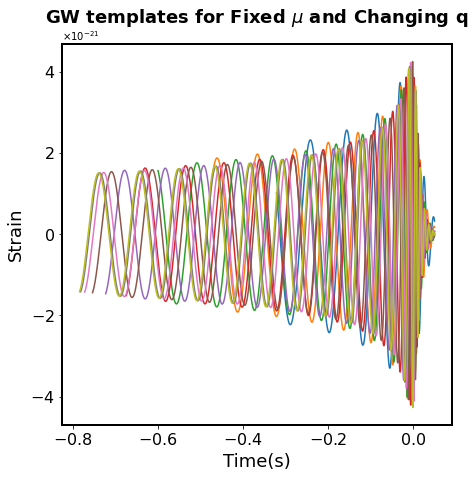

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
%matplotlib inline

mu = 45
d = 500
q = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
temps = []

fig,ax = plt.subplots(figsize=(7,7))
for j in range(len(q)):
    m1 = (1+1/q[j])*mu
    m2 = m1*q[j]

    template, _ = get_td_waveform(mass1 = m1, mass2 = m2, distance=d,
                            approximant="SEOBNRv4_opt", delta_t=1/4096, f_lower =10)
    template = template.time_slice(start = template.start_time, end=0.05)
    ax.plot(template.sample_times, template)
    xlabel, ylabel, title = 'Time(s)', 'Strain', 'GW templates for Fixed $\mu$ and Changing q'
    format_plt(ax, xlabel, ylabel, title)
    temps.append(template)





The Strain amplitude mainly depends on μ and $D_L$. These templates' amplitudes are similar as the above parameters are constant.

I also applied a timeslice for to remove 0 data points. keeping those points would reduce the power spectal density (PSD).

Next, I'll get the PSD for detectors and the templates for comparison. The black curves show the PSD of templates. Higher mass ratios have darker shades.

(1e-49, 1e-39)

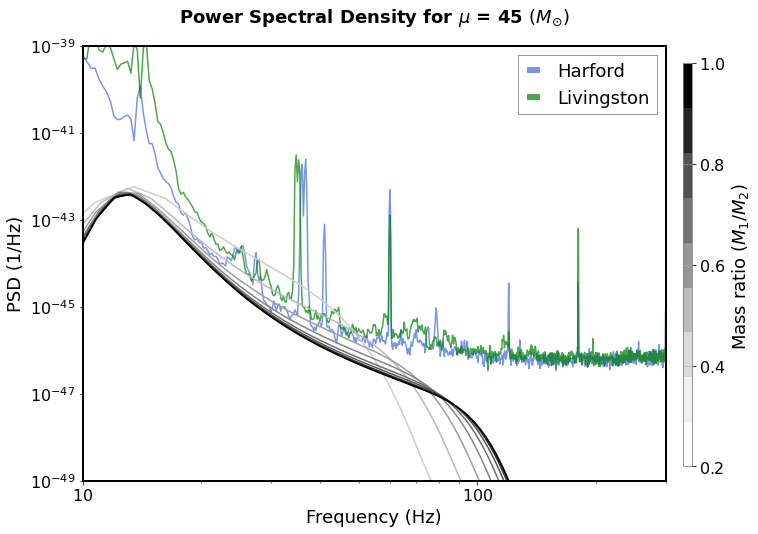

In [21]:
from gwpy.timeseries import TimeSeries
import matplotlib as mpl

Hgwpy = TimeSeries.from_pycbc(H)
Hpsd = Hgwpy.psd(fftlength=4)

Lgwpy = TimeSeries.from_pycbc(L)
Lpsd = Lgwpy.psd(fftlength=4)


mdot = '$ (M_{\odot})$'
fig,ax = plt.subplots(figsize=(12,8))
ax.loglog(Hpsd.frequencies, Hpsd, color = 'royalblue', alpha = 0.7, label = 'Harford')
ax.loglog(Lpsd.frequencies, Lpsd, color = 'green', alpha = 0.7, label = 'Livingston')

c = plt.cm.Greys(np.linspace(0.3,1,len(q)))
for i in range(len(q)):
  
  Template = TimeSeries.from_pycbc(temps[i])
  length = temps[i].duration
  PSD = Template.psd(fftlength=length)
  ax.loglog(PSD.frequencies, PSD, color = c[i])

xlabel, ylabel, title = 'Frequency (Hz)', 'PSD (1/Hz)', 'Power Spectral Density for $\mu$ = 45 ' + mdot
bar = np.linspace(0.2,1,5)
format_plt(ax, xlabel, ylabel, title, bar, legend=True)
ax.set_xlim([10,300])
ax.set_ylim([10**(-49), 10**(-39)])


The PSD for lower q is larger in comparison at lower frequencies. Such signals must have higher SNRs than the ones with higher q.

Now, I'll inject these signals into the strain data and determine the SNRs from both detectors

### SNR of Injected Signals

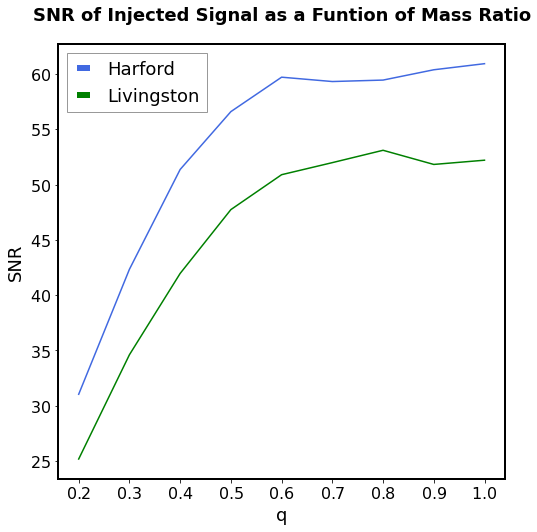

In [22]:
from pycbc.filter import matched_filter

fig,ax = plt.subplots(figsize=(8,8))

SNR = []
SNR.append([])
SNR.append([])
for i in range(len(q)):
  GW = temps[i]
  GWdet=GW.copy()
  GWinj = GW.copy()

  GWdet.resize(len(H))
  GWdet = GWdet.cyclic_time_shift(GWdet.start_time)
  GWinj.start_time = 41

  for D, i in zip([H,L], [0,1]):
    SNR.append([])
    inj = D.copy()
    inj = inj.inject(GWinj)
    PSD = inj.filter_psd(4, inj.delta_f, flow = 10)

    snr = matched_filter(GWdet, inj,
                    psd=PSD, low_frequency_cutoff=10)
    snr = snr.crop(4 + 4, 4)
    snr = max(np.array(abs(snr)))

    SNR[i].append(snr)

ax.plot(q, SNR[0], color='royalblue', label='Harford')
ax.plot(q, SNR[1], color='green', label='Livingston')

xlabel, ylabel, title = 'q', 'SNR', 'SNR of Injected Signal as a Funtion of Mass Ratio'
format_plt(ax, xlabel, ylabel, title, legend=True)





Contrary to what I belived, lower q have lower SNR. This must be because the PSD of signals with lower q are lower at higher frequencies.

Lets see if this trend is consistent among signals with other μ. In the next plot, the shade of curves indicate the value of μ

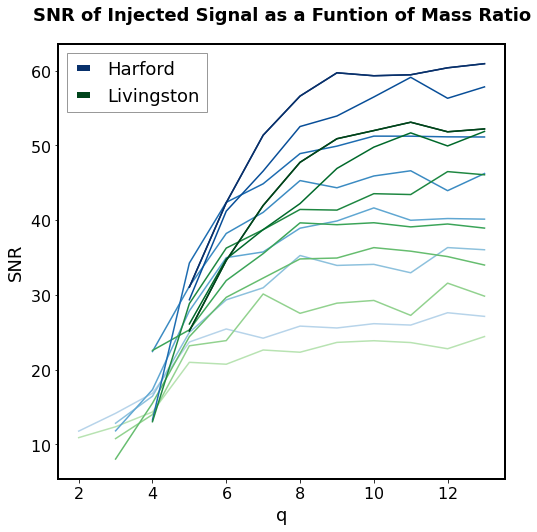

In [23]:
mu = np.array([15,20, 25,30, 35,40,45])
q = np.array([0.01, 0.03,0.05, 0.08, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
d = 500

fig,ax = plt.subplots(figsize=(8,8))
cH = plt.cm.Blues(np.linspace(0.3,1,len(mu)))
cL = plt.cm.Greens(np.linspace(0.3,1,len(mu)))
for i in range(len(mu)):
  Q = []
  SNR = []
  SNR.append([])
  SNR.append([])
  for j in range(len(q)):
      m1 = (1+1/q[j])*mu[i]
      m2 = m1*q[j]
      if q[j] == 0.7:
        MU = m1*m2/(m1+m2)
      
      if m1 < 400 and m2 > 1.5:
        template, _ = get_td_waveform(mass1 = m1, mass2 = m2, distance=d,
                            approximant="SEOBNRv4_opt", delta_t=1/4096, f_lower =10)
        template = template.time_slice(start = template.start_time, end=0.05)
        Q.append(j)


        GWdet=template.copy()
        GWinj = template.copy()

        GWdet.resize(len(H))
        GWdet = GWdet.cyclic_time_shift(GWdet.start_time)
        GWinj.start_time = 41

        for D, k in zip([H,L], [0,1]):
          inj = D.copy()
          inj = inj.inject(GWinj)
          PSD = inj.filter_psd(4, inj.delta_f, flow = 10)

          snr = matched_filter(GWdet, inj,
                    psd=PSD, low_frequency_cutoff=10)
          snr = snr.crop(4 + 4, 4)
          snr = max(np.array(abs(snr)))

          SNR[k].append(snr)
  if i == 6:
    ax.plot(Q, SNR[0], color=cH[i], label = 'Harford')
    ax.plot(Q, SNR[1], color=cL[i], label = 'Livingston')

  ax.plot(Q, SNR[0], color=cH[i])
  ax.plot(Q, SNR[1], color=cL[i])

xlabel, ylabel, title = 'q', 'SNR', 'SNR of Injected Signal as a Funtion of Mass Ratio'
format_plt(ax, xlabel, ylabel, title, legend=True)



        



This trend is consistent among signal with different μ.

**Merger Events with a given μ will have nearly same strain amplitudes. However, thier detectibilty might be lower if they have unequal masses.**